## Interval Analysis

In [9]:
# !pip install tensorboardX

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
# from tensorboardX import SummaryWriter

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Simple NN. You can change this if you want. If you change it, mention the architectural details in your report.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200,10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = x.view((-1, 28*28)) # implemented in the analysis function
        x = self.relu(self.fc(x))
        x = self.fc2(x)
        x = self.softmax(x) # added softmax for probabilities
        return x

class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), Net())

model = model.to(device)
model.train()


Sequential(
  (0): Normalize()
  (1): Net(
    (fc): Linear(in_features=784, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=10, bias=True)
    (relu): ReLU()
    (softmax): Softmax(dim=-1)
  )
)

In [10]:
def train_model(model, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.3f}')

def test_model(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Accuracy on images: {100 * correct / total}')

In [11]:
train_model(model, 15)
test_model(model)

Epoch 1/15, Loss: 2.012
Epoch 2/15, Loss: 1.729
Epoch 3/15, Loss: 1.627
Epoch 4/15, Loss: 1.596
Epoch 5/15, Loss: 1.582
Epoch 6/15, Loss: 1.572
Epoch 7/15, Loss: 1.566
Epoch 8/15, Loss: 1.561
Epoch 9/15, Loss: 1.557
Epoch 10/15, Loss: 1.553
Epoch 11/15, Loss: 1.550
Epoch 12/15, Loss: 1.547
Epoch 13/15, Loss: 1.545
Epoch 14/15, Loss: 1.542
Epoch 15/15, Loss: 1.540
Accuracy on images: 93.43


### Write the interval analysis for the simple model.

 Implement interval analysis for your network. Use this to measure the robustness for the whole test set of your network for 10 l∞ neighborhoods, sized evenly between 0.01 and 0.1 (inclusive). Report the verified accuracy (the percentage of the images that are successfully verified) for those different values chosen. As usual, present your observations clearly along with experimental evidence (numbers, images, etc.) in your submission.

In [15]:
!pip install bound-propagation

import bound_propagation as bp
from bound_propagation import IntervalBounds

# --- INTERVAL ANALYSIS SETUP ---

# 1. Create Verification Model and Transfer Weights
# This model uses the same layers but outputs raw LOGITS for verification.
class LogitNet(nn.Module):
    def __init__(self):
        super(LogitNet, self).__init__()
        # Use standard nn.Linear and ReLU modules
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200, 10)
        self.relu = nn.ReLU()
        # Softmax is omitted for logit analysis

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = self.relu(self.fc(x))
        x = self.fc2(x)
        return x

verification_model = nn.Sequential(Normalize(), LogitNet())
verification_model.to(device)

# Transfer weights from the TRAINED model (model) to the verification_model
with torch.no_grad():
    # model[1] is the trained Net, verification_model[1] is the LogitNet
    verification_model[1].fc.weight.data.copy_(model[1].fc.weight.data)
    verification_model[1].fc.bias.data.copy_(model[1].fc.bias.data)
    verification_model[1].fc2.weight.data.copy_(model[1].fc2.weight.data)
    verification_model[1].fc2.bias.data.copy_(model[1].fc2.bias.data)

In [16]:
# --- 2. Interval Propagation Function (Standard IBP Equations) ---
def get_interval_bounds(model, x, epsilon):
    """
    Performs manual Interval Bound Propagation (IBP) reflecting the
    Linear -> ReLU -> Linear architecture.
    """

    # 1. Calculate and Normalize Bounds on TENSORS
    L = x - epsilon
    U = x + epsilon
    L = torch.clamp(L, 0, 1)
    U = torch.clamp(U, 0, 1)

    mean, std = 0.1307, 0.3081
    L_norm = (L - mean) / std
    U_norm = (U - mean) / std

    net = model[1] # This is the LogitNet module

    # 2. Manual View Operation (Flattening)
    L_flat = L_norm.view((-1, 28*28))
    U_flat = U_norm.view((-1, 28*28))

    # --- Layer 1: fc (Linear) ---
    # Equation: L = W_pos * L + W_neg * U + b
    W1, b1 = net.fc.weight, net.fc.bias
    W1_pos = F.relu(W1)
    W1_neg = -F.relu(-W1)

    L1 = F.linear(L_flat, W1_pos, None) + F.linear(U_flat, W1_neg, b1)
    U1 = F.linear(U_flat, W1_pos, None) + F.linear(L_flat, W1_neg, b1)

    # --- Layer 2: ReLU ---
    # Equation: ReLU(L, U) = [ReLU(L), ReLU(U)]
    L2 = F.relu(L1)
    U2 = F.relu(U1)

    # --- Layer 3: fc2 (Linear) ---
    W2, b2 = net.fc2.weight, net.fc2.bias
    W2_pos = F.relu(W2)
    W2_neg = -F.relu(-W2)

    L_final = F.linear(L2, W2_pos, None) + F.linear(U2, W2_neg, b2)
    U_final = F.linear(U2, W2_pos, None) + F.linear(L2, W2_neg, b2)

    return L_final, U_final


# --- 3. Robustness Verification Function ---
def verify_robustness(model, test_loader, epsilon):
    model.eval()
    verified_count = 0
    total_samples = 0

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)

            # Use the original model for clean prediction (it outputs probabilities/softmax)
            clean_probs = model(images)
            _, predicted_labels = torch.max(clean_probs, 1)

            # Get interval bounds (L, U are on logits from the verification_model)
            L, U = get_interval_bounds(model, images, epsilon)

            for j in range(images.size(0)):
                total_samples += 1
                true_label = labels[j]
                predicted_label = predicted_labels[j]

                # Only verify correctly classified samples
                if true_label.item() == predicted_label.item():
                    L_true = L[j, predicted_label]

                    # Find max upper bound of all incorrect classes
                    incorrect_indices = torch.arange(10).to(device) != predicted_label
                    U_other_max = torch.max(U[j, incorrect_indices])

                    # Robustness condition: L_true > max(U_other)
                    if L_true > U_other_max:
                        verified_count += 1

    verified_accuracy = (verified_count / len(test_loader.dataset)) * 100
    return verified_accuracy


<>:20: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:20: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-49839412.py:20: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Verified Robustness vs. Perturbation Epsilon ($\ell_\infty$ norm)')
/tmp/ipython-input-49839412.py:21: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('Epsilon ($\epsilon$)')



--- Running Manual IBP Robustness Verification ---
Verifying for epsilon=0.010... Verified Accuracy: 49.59%
Verifying for epsilon=0.020... Verified Accuracy: 5.30%
Verifying for epsilon=0.030... Verified Accuracy: 0.20%
Verifying for epsilon=0.040... Verified Accuracy: 0.00%
Verifying for epsilon=0.050... Verified Accuracy: 0.00%
Verifying for epsilon=0.060... Verified Accuracy: 0.00%
Verifying for epsilon=0.070... Verified Accuracy: 0.00%
Verifying for epsilon=0.080... Verified Accuracy: 0.00%
Verifying for epsilon=0.090... Verified Accuracy: 0.00%
Verifying for epsilon=0.100... Verified Accuracy: 0.00%


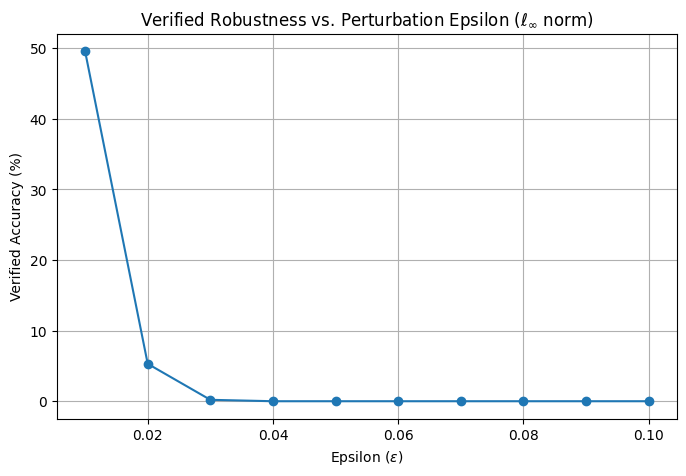

In [17]:
# --- 4. Execution and Plotting ---

epsilons = np.linspace(0.01, 0.1, 10)
eps_values = []
acc_values = []

print("\n--- Running Manual IBP Robustness Verification ---")

# Run verification on the specialized model
for epsilon in epsilons:
    # We pass the verification_model wrapper, which contains the LogitNet
    verified_acc = verify_robustness(verification_model, test_loader, epsilon)
    eps_values.append(epsilon)
    acc_values.append(verified_acc)
    print(f"Verifying for epsilon={epsilon:.3f}... Verified Accuracy: {verified_acc:.2f}%")

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(eps_values, acc_values, marker='o')
plt.title('Verified Robustness vs. Perturbation Epsilon ($\ell_\infty$ norm)')
plt.xlabel('Epsilon ($\epsilon$)')
plt.ylabel('Verified Accuracy (%)')
plt.grid(True)
plt.show()